In [2]:
import mlflow
import pandas as pd
import numpy as np
from catboost import CatBoostClassifier
from process_and_ml.data_wrangler import load_azdias
import shap

In [3]:
from config import settings
path_test_udacity = '../data/train_test_files/Udacity_MAILOUT_052018_TRAIN.csv'

In [4]:
train_df_compare = load_azdias(path_test_udacity)

Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.


In [5]:
d19_social= train_df_compare['D19_SOZIALES']

In [6]:
customers = pd.read_csv('../data/cleaned_data/customers_clean.csv', index_col=[0]).sample(frac=0.4, random_state=settings.RANDOM_STATE)

In [7]:
#population = pd.read_csv('../data/cleaned_data/azdias_clean.csv', index_col=[0]).sample(frac=0.4, random_state=settings.RANDOM_STATE)
df_info_columns = pd.read_excel('/home/jair/Documents/arvato_project/data/dataframe_info/DIAS Information Levels - Attributes 2017.xlsx', engine='openpyxl')
column_array = df_info_columns.iloc[0].values
column_array[0] = 'to_drop'
df_info_columns.columns = column_array

df_info_columns.drop('to_drop', axis=1, inplace=True)
df_info_columns = df_info_columns.iloc[1:]

In [8]:
df_column_attributes = pd.read_excel('/home/jair/Documents/arvato_project/data/dataframe_info/DIAS Attributes - Values 2017.xlsx', engine='openpyxl')
column_array = df_column_attributes.iloc[0].values
column_array[0] = 'to_drop'
df_column_attributes.columns = column_array
df_column_attributes.drop('to_drop', axis=1, inplace=True)
df_column_attributes =df_column_attributes.iloc[1:]


In [9]:
columns_with_info = df_info_columns.Attribute.unique()
columns_with_attributes = df_column_attributes.Attribute.unique()

In [10]:
columns_with_attributes = np.delete(columns_with_attributes, 1)
columns_with_info = np.unique(np.concatenate((columns_with_info, columns_with_attributes)))

In [11]:
columns_with_attributes = [col for col in columns_with_info if col  in train_df_compare]


In [12]:
cod_nan = pd.read_csv('/home/jair/Documents/arvato_project/data/wrangler/azdias_costumer_to_nan.csv')

In [13]:
cod_nan.drop(cod_nan.columns[0], axis=1, inplace=True)


In [14]:
cod_nan.set_index('Attribute', inplace=True)

In [15]:
dict_to_nan = cod_nan.to_dict()['Value']
for key, value in dict_to_nan.items():
    if len(value)> 2:
        dict_to_nan[key] = [int(num) for num in value.split(',')]
    else:
        dict_to_nan[key] = int(value)

In [16]:
dict_to_nan['CAMEO_DEUG_2015'] = [-1,'X']
dict_to_nan['CAMEO_DEU_2015'] = [-1,'XX']
dict_to_nan['CAMEO_DEUINTL_2015'] = [-1,'XX']



In [17]:
bip_flag = dict_to_nan.pop('BIP_FLAG')

In [18]:
response = train_df_compare['RESPONSE']

In [19]:
df_test_cols = train_df_compare.columns
for key, value, in dict_to_nan.items():
    if key in df_test_cols:
        train_df_compare[key] = train_df_compare[key].replace(value, np.nan)

In [20]:
#test_df_compare, lnr = load_test_file(path_test_udacity)
# create cols
from process_and_ml.feature_engineer import fs_for_cat_part_one, fs_for_cat_part_two


In [21]:
checking_test = fs_for_cat_part_one(train_df_compare)


In [22]:
checking_test = fs_for_cat_part_two(train_df_compare)

In [23]:
last_train = checking_test[customers.columns]

In [24]:
last_train.to_csv('../data/cleaned_data/train_cleaned.csv')

In [26]:
cat_features = ['CAMEO_DEU_2015', 'OST_WEST_KZ']

In [27]:
from process_and_ml.pipeline import cat_features_fill_na, preprocessing_baseline
train_final = cat_features_fill_na(last_train, cat_features=['CAMEO_DEU_2015', 'OST_WEST_KZ'])

In [31]:
from process_and_ml.pipeline import load_catboost_model, show_metrics_baseline, compute_metrics, cat_features_fill_na, preprocessing_baseline

catboost_azdias = load_catboost_model('catboost_first.cbm')


In [37]:
#checking catboost train and model
metrics_returned = compute_metrics(catboost, train_final, response)


In [29]:
#train with train file
last_train['is_customer'] = response.values
features, labels = preprocessing_baseline(last_train,
                                          cat_features=cat_features,
                                          target='is_customer')


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [27]:
X_train, X_test, X_valid = features
y_train, y_test, y_valid = labels
class_weights = (1, sum(y_train == 0) / sum(y_train == 1))

In [28]:
params_catboost = dict(num_trees=30,
                       task_type='GPU',
                       max_depth=5,
                       min_child_samples=30,
                       one_hot_max_size=5,
                       class_weights=class_weights,
                       cat_features=cat_features,
                       random_state=settings.RANDOM_STATE,
                       eval_metric='AUC',
                       od_type='Iter',
                       od_wait=40)

In [29]:
tags = {'algo':'catboost',
        'datasets':'train',
        'sample':1,
        'cols':cat_features,
        'rows':last_train.shape[0]}
run_name = 'cat_train_dataset'

In [60]:
from pathlib import Path
path = (
    Path('.') if Path('.').resolve().name == 'arvato_project'
    else Path('..')
)

In [61]:
path

PosixPath('..')

In [62]:
path_mlflow = path / 'mlruns'
mlflow.set_tracking_uri(str(path_mlflow))
#experiment_id = mlflow.create_experiment('CatBoostClassifier')


mlflow.get_tracking_uri()

'../mlruns'

## Set new experiment

In [63]:
mlflow.set_experiment(experiment_name='CatBoostClassifier')

In [30]:
catboost = CatBoostClassifier(**params_catboost)

with mlflow.start_run(tags=tags):
    mlflow.log_params(params_catboost)
    catboost.fit(X_train, y_train, eval_set=(X_valid, y_valid), verbose=False)
    metrics_returned = show_metrics_baseline(catboost, features=features, labels=labels)
    mlflow.log_metrics(metrics_returned)

Accuracy Train: 0.6176304326139727
AUC Train: 0.7487339316984729
Accuracy Test: 0.6134388578522657
AUC Test: 0.599011038654934
Accuracy Valid: 0.6117920868890613
AUC Valid: 0.6260516496465043


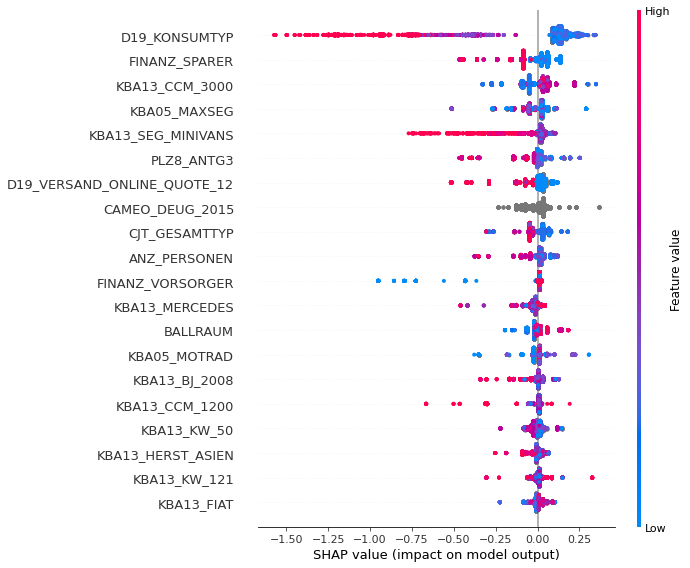

In [31]:
explainer = shap.TreeExplainer(catboost)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test)


In [38]:
#fillna

last_train = cat_features_fill_na(last_train, cat_features)

In [39]:
#including D19 SOLIALES
metrics_with_azdias = compute_metrics(catboost_azdias, last_train, response)

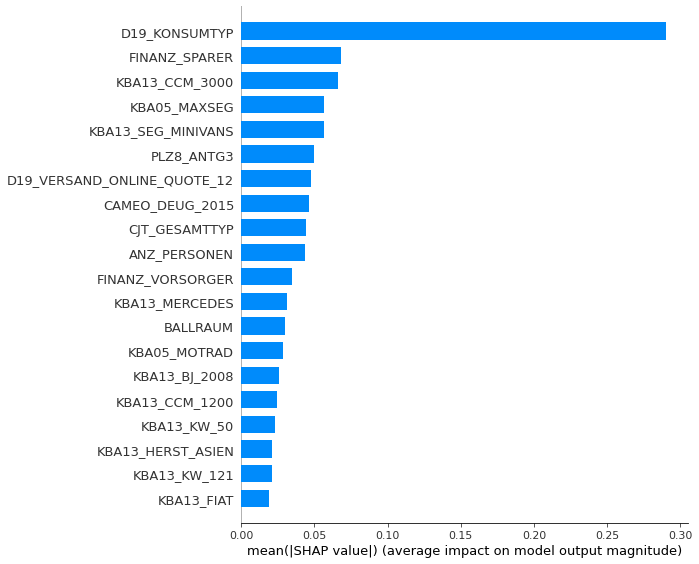

In [40]:

shap.summary_plot(shap_values, X_test, plot_type='bar')

In [32]:
pred_auc = catboost_azdias.predict_proba(train_final)[:, 1]

In [35]:
d19_social['pred_auc'] = pred_auc


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [37]:
pred_auc_2 = catboost_azdias.predict_proba(train_final)


In [28]:
from process_and_ml.pipeline import load_catboost_model


In [30]:
catboost = load_catboost_model('catboost_first.cbm')

In [31]:
y_pred = catboost.predict_proba(last_train)[:, 1]


CatBoostError: Invalid type for cat_feature[non-default value idx=8,feature_idx=9]=nan : cat_features must be integer or string, real number values and NaN values should be converted to string.